In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

import kagglehub

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [ ]:
path = kagglehub.dataset_download("murtozalikhon/brain-tumor-multimodal-image-ct-and-mri")
mri_root = os.path.join(path, "Dataset", "Brain Tumor MRI images")

print("MRI Root:", mri_root)

Using Colab cache for faster access to the 'brain-tumor-multimodal-image-ct-and-mri' dataset.
MRI Root: /kaggle/input/brain-tumor-multimodal-image-ct-and-mri/Dataset/Brain Tumor MRI images


In [ ]:
classes = ["Healthy", "Tumor"]
image_paths = []
labels = []

for label, cls in enumerate(classes):
    folder = os.path.join(mri_root, cls)
    for f in os.listdir(folder):
        if f.lower().endswith((".png", ".jpg", ".jpeg")):
            image_paths.append(os.path.join(folder, f))
            labels.append(label)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("Total images:", len(image_paths))
print("Class counts:", np.bincount(labels))

Total images: 5000
Class counts: [2000 3000]


In [ ]:
IMAGE_SIZE = 224

def load_mri(path):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

    # Normalize intensity inside image
    img = (img - img.mean()) / (img.std() + 1e-6)

    # Convert grayscale → RGB for ResNet input
    img = np.stack([img, img, img], axis=2)  # shape: (224,224,3)
    img = (img * 255).astype(np.uint8)
    return img

In [ ]:
class MRIDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = load_mri(self.paths[idx])
        img = Image.fromarray(img)

        if self.transform:
            img = self.transform(img)

        return img, self.labels[idx]

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
def build_resnet18():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(512, 2)
    return model.to(device)

In [ ]:
cls_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels),
    y=labels
)
weights = torch.tensor(cls_weights, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=weights)

print("Class Weights:", weights)

Class Weights: tensor([1.2500, 0.8333], device='cuda:0')


In [ ]:
def run_epoch(loader, train, model, optimizer):
    model.train() if train else model.eval()

    preds_all, targs_all = [], []
    total_loss = 0

    with torch.set_grad_enabled(train):
        for imgs, ys in loader:
            imgs, ys = imgs.to(device), ys.to(device)

            logits = model(imgs)
            loss = criterion(logits, ys)

            if train:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            preds = torch.argmax(logits, dim=1)
            preds_all.extend(preds.cpu().numpy())
            targs_all.extend(ys.cpu().numpy())

            total_loss += loss.item() * imgs.size(0)

    acc = accuracy_score(targs_all, preds_all)
    f1  = f1_score(targs_all, preds_all)
    loss = total_loss / len(loader.dataset)

    return loss, acc, f1

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1 = 0
best_state = None

LR = 1e-4
BATCH = 32
WD = 1e-4
EPOCHS = 10

In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(image_paths, labels), 1):
    print(f"\n FOLD {fold} ")

    train_ds = MRIDataset(image_paths[train_idx], labels[train_idx], transform=train_transform)
    val_ds   = MRIDataset(image_paths[val_idx],   labels[val_idx],   transform=val_transform)

    train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False)

    model = build_resnet18()
    optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WD)

    best_fold_f1 = 0
    best_fold_state = None

    for epoch in range(1, EPOCHS+1):
        train_loss, train_acc, train_f1 = run_epoch(train_loader, True,  model, optimizer)
        val_loss,   val_acc,   val_f1   = run_epoch(val_loader,   False, model, optimizer)

        print(f"Epoch {epoch:02d} | Val F1 = {val_f1:.4f}")

        if val_f1 > best_fold_f1:
            best_fold_f1 = val_f1
            best_fold_state = model.state_dict()

    if best_fold_f1 > best_f1:
        best_f1 = best_fold_f1
        best_state = best_fold_state


torch.save(best_state, "best_resnet18.pt")
print("\n BEST MODEL F1:", best_f1)



 FOLD 1 
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


Epoch 01 | Val F1 = 0.9883
Epoch 02 | Val F1 = 0.9788
Epoch 03 | Val F1 = 0.9883
Epoch 04 | Val F1 = 0.9883
Epoch 05 | Val F1 = 0.9874
Epoch 06 | Val F1 = 0.9849
Epoch 07 | Val F1 = 0.9883
Epoch 08 | Val F1 = 0.9883
Epoch 09 | Val F1 = 0.9874
Epoch 10 | Val F1 = 0.9762

 FOLD 2 
Epoch 01 | Val F1 = 0.9874
Epoch 02 | Val F1 = 0.9933
Epoch 03 | Val F1 = 0.9891
Epoch 04 | Val F1 = 0.9916
Epoch 05 | Val F1 = 0.9900
Epoch 06 | Val F1 = 0.9884
Epoch 07 | Val F1 = 0.9365
Epoch 08 | Val F1 = 0.9933
Epoch 09 | Val F1 = 0.9917
Epoch 10 | Val F1 = 0.9900

 FOLD 3 
Epoch 01 | Val F1 = 0.9908
Epoch 02 | Val F1 = 0.9942
Epoch 03 | Val F1 = 0.9950
Epoch 04 | Val F1 = 0.9925
Epoch 05 | Val F1 = 0.9639
Epoch 06 | Val F1 = 0.9834
Epoch 07 | Val F1 = 0.9909
Epoch 08 | Val F1 = 0.9958
Epoch 09 | Val F1 = 0.9942
Epoch 10 | Val F1 = 0.9950

 FOLD 4 
Epoch 01 | Val F1 = 0.9875
Epoch 02 | Val F1 = 0.9917
Epoch 03 | Val F1 = 0.9908
Epoch 04 | Val F1 = 0.9882
Epoch 05 | Val F1 = 0.9788
Epoch 06 | Val F1 = 0.872

In [ ]:
best_model = build_resnet18()
best_model.load_state_dict(torch.load("best_resnet18.pt"))
best_model.eval()

print("Loaded best ResNet18 model.")

Loaded best ResNet18 model.


In [ ]:
class ResNetCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.activations = None
        self.gradients = None

        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def generate(self, x):
        self.model.zero_grad()

        logits = self.model(x)
        probs = torch.softmax(logits, dim=1)

        tumor_prob = probs[0, 1]
        tumor_prob.backward(retain_graph=True)

        A = self.activations[0]     # (C,H,W)
        dA = self.gradients[0]      # (C,H,W)

        weights = dA.mean(dim=[1,2])
        cam = torch.zeros(A.shape[1:], device=x.device)

        for c, w in enumerate(weights):
            cam += w * A[c]

        cam = F.relu(cam)
        cam = cam / (cam.max() + 1e-6)
        return cam.cpu().numpy()

In [ ]:
target_layer = best_model.layer4[-1]
cam_obj = ResNetCAM(best_model, target_layer)

In [ ]:
def visualize_cam(path, cam_obj):
    raw = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    raw = cv2.resize(raw, (224,224))
    raw_rgb = cv2.cvtColor(raw, cv2.COLOR_GRAY2RGB)

    img = Image.fromarray(raw).convert("RGB")
    tensor = val_transform(img).unsqueeze(0).to(device)

    cam = cam_obj.generate(tensor)
    cam_resized = cv2.resize(cam, (224,224))

    heat = cv2.applyColorMap((cam_resized * 255).astype(np.uint8), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

    overlay = cv2.addWeighted(raw_rgb, 0.5, heat, 0.5, 0)
    return raw_rgb, heat, overlay

In [ ]:
healthy_idx = np.where(labels == 0)[0]
tumor_idx   = np.where(labels == 1)[0]

healthy_samples = np.random.choice(healthy_idx, 3, replace=False)
tumor_samples   = np.random.choice(tumor_idx, 3, replace=False)

sample_paths = np.concatenate([image_paths[healthy_samples],
                               image_paths[tumor_samples]])

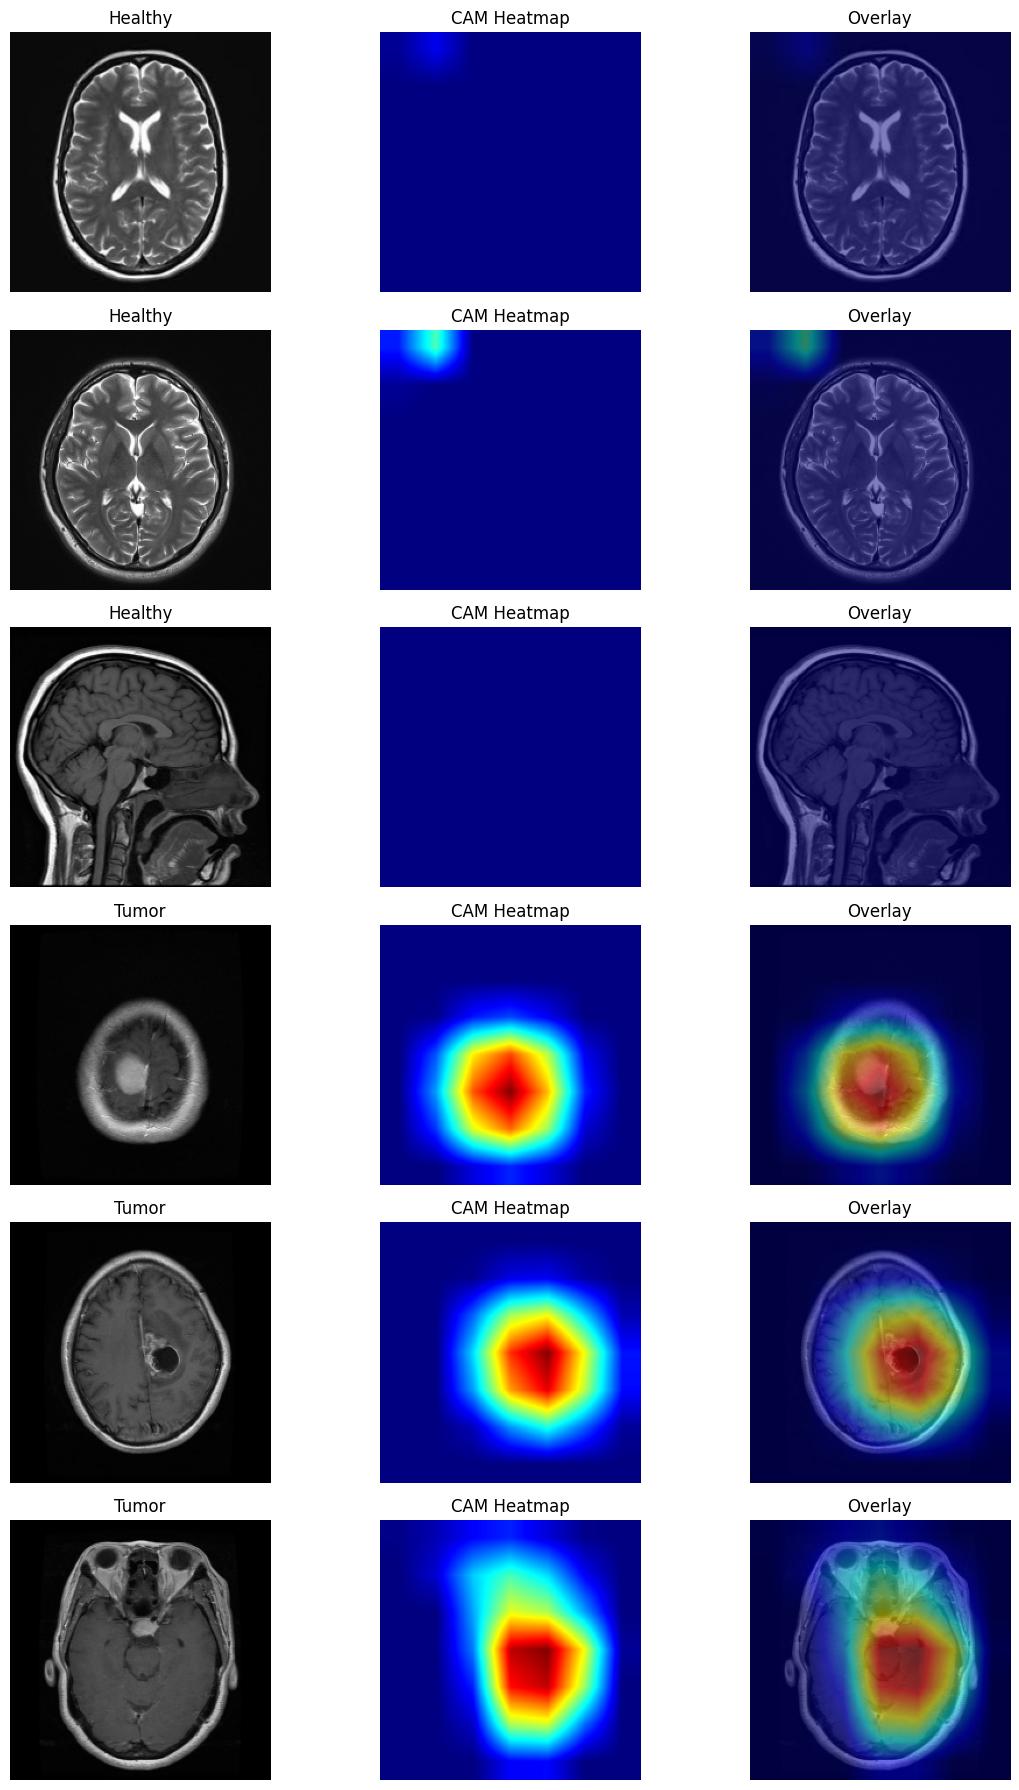

In [ ]:
plt.figure(figsize=(12,18))

for i, p in enumerate(sample_paths):
    raw, heat, overlay = visualize_cam(p, cam_obj)

    plt.subplot(6,3,i*3+1)
    plt.imshow(raw)
    plt.title("Healthy" if i < 3 else "Tumor")
    plt.axis("off")

    plt.subplot(6,3,i*3+2)
    plt.imshow(heat)
    plt.title("CAM Heatmap")
    plt.axis("off")

    plt.subplot(6,3,i*3+3)
    plt.imshow(overlay)
    plt.title("Overlay")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
def cam_focus_score(cam):
    k = int(cam.size * 0.2)
    top = np.partition(cam.flatten(), -k)[-k:]
    return top.mean()

all_cam_scores = []
all_confidences = []
all_labels = []

for path, label in zip(image_paths, labels):
    raw = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    raw = cv2.resize(raw, (224,224))

    img = Image.fromarray(raw).convert("RGB")

    tensor = val_transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = best_model(tensor)
        prob = torch.softmax(logits, dim=1)[0,1].item()

    cam = cam_obj.generate(tensor)

    score = cam_focus_score(cam)

    all_confidences.append(prob)
    all_cam_scores.append(score)
    all_labels.append(label)


In [ ]:
all_cam_scores = np.array(all_cam_scores)
all_confidences = np.array(all_confidences)
all_labels = np.array(all_labels)

In [ ]:
healthy_scores = all_cam_scores[all_labels == 0]
tumor_scores   = all_cam_scores[all_labels == 1]

In [ ]:
corr = np.corrcoef(all_confidences, all_cam_scores)[0,1]

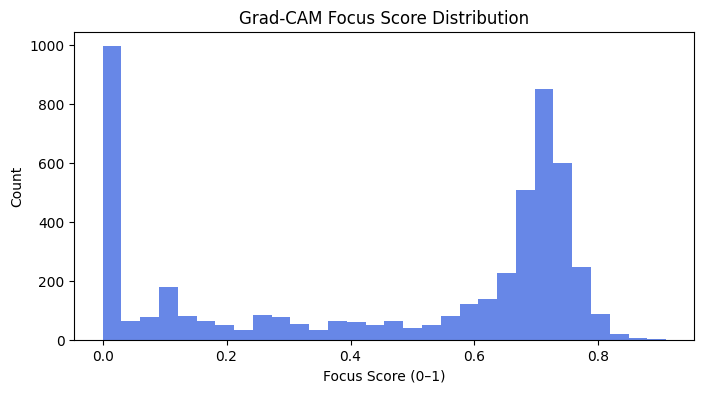

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(all_cam_scores, bins=30, color="royalblue", alpha=0.8)
plt.title("Grad-CAM Focus Score Distribution")
plt.xlabel("Focus Score (0–1)")
plt.ylabel("Count")
plt.show()

/tmp/ipython-input-582394981.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([healthy_scores, tumor_scores], labels=["Healthy", "Tumor"])


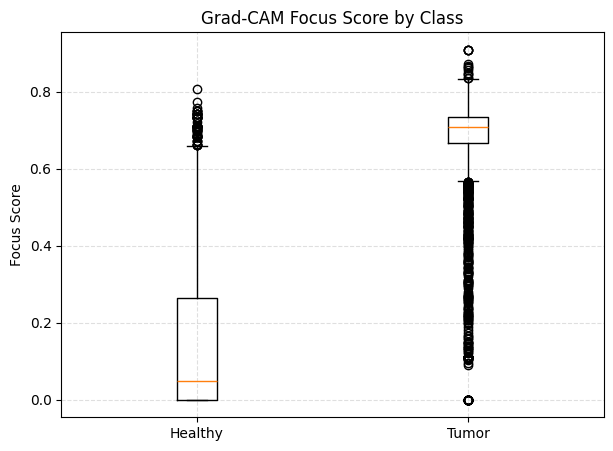

In [ ]:
plt.figure(figsize=(7,5))
plt.boxplot([healthy_scores, tumor_scores], labels=["Healthy", "Tumor"])
plt.title("Grad-CAM Focus Score by Class")
plt.ylabel("Focus Score")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

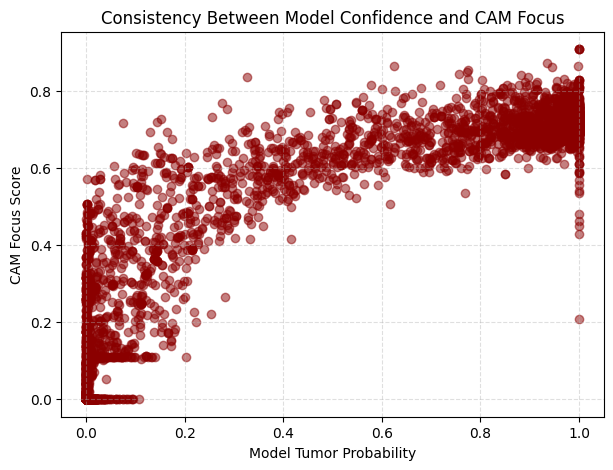

In [ ]:
plt.figure(figsize=(7,5))
plt.scatter(all_confidences, all_cam_scores, alpha=0.5, color="darkred")
plt.xlabel("Model Tumor Probability")
plt.ylabel("CAM Focus Score")
plt.title("Consistency Between Model Confidence and CAM Focus")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()

In [ ]:
print("=== UPDATED GRAD-CAM SUMMARY ===")
print("Correlation (Confidence ↔ CAM):", corr)
print("Healthy CAM Mean:", healthy_scores.mean())
print("Tumor CAM Mean:", tumor_scores.mean())

=== UPDATED GRAD-CAM SUMMARY ===
Correlation (Confidence ↔ CAM): 0.9069393240119717
Healthy CAM Mean: 0.15358835
Tumor CAM Mean: 0.671347
